In [183]:
import pandas as pd
import matplotlib.pyplot as plt

from numpyro.infer import MCMC, NUTS, Predictive
import jax.random as random

import numpyro
import numpyro.distributions as dist

import jax.numpy as jnp

import arviz as az

<AxesSubplot:>

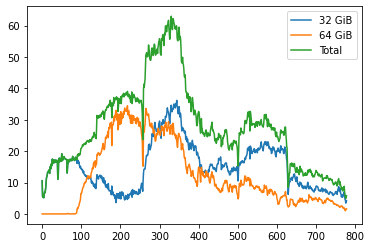

In [210]:
# downloaded from https://dashboard.starboard.ventures/dashboard
df = pd.read_csv('/Users/tom/Downloads/Sector_Onboarding_Breakdown_by_Sector_Size(3).csv')
df.plot()

In [32]:
X_ = df['32 GiB'].index.values
y_ = df['32 GiB'].values

In [340]:
# make a model that describes the data at as a random walk
# with bi-weekly innovations + covariate that multiplicatively
# decreases onboarding after some break point
def rw_model2(y=None, X=None, periodicity=14,breakpoint_idx=620):
    y_sigma = numpyro.sample('y_sigma', dist.HalfNormal(scale=1))
    covariate_effect_size = numpyro.sample('covariate_effect_size', dist.Normal(loc=1,scale=0.1))
    nsteps = X.shape[0] // periodicity
    mu = numpyro.sample('rw', dist.GaussianRandomWalk(scale=1, num_steps=nsteps))
    mu = jnp.repeat(mu, periodicity)
    mu = jnp.append(mu, jnp.repeat(mu[-1], X.shape[0] % periodicity))
    covariate = jnp.concatenate([jnp.repeat(1.,breakpoint_idx), 
                                 covariate_effect_size * jnp.repeat(1.,len(y_)-breakpoint_idx)])
    mu *= covariate
    print(covariate)
    print(mu)
    numpyro.sample('obs', dist.Normal(loc=mu, scale=y_sigma), obs=y)

In [341]:
# Run the model with a breakpoint at idx 652 (~1 week for Skyr upgrade)
# As a test to see if i) model fits data ii) breakpoint effect size is reasonable
INOVATIONS = 14
BREAKPOINT_idx=620
mcmc = MCMC(
            NUTS(rw_model2), 
            num_warmup=1000, num_samples=500)
mcmc.run(random.PRNGKey(0), y=y_, X=X_, periodicity=INOVATIONS, breakpoint_idx=BREAKPOINT_idx)

[1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.       

  0%|                                                                            | 0/1500 [00:00<?, ?it/s]

Traced<ShapedArray(float32[779])>with<JVPTrace(level=4/1)> with
  primal = Traced<ShapedArray(float32[779])>with<DynamicJaxprTrace(level=2/1)>
  tangent = Traced<ShapedArray(float32[779])>with<JaxprTrace(level=3/1)> with
    pval = (ShapedArray(float32[779]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe9b6d237f0>, invars=(Traced<ShapedArray(float32[620]):JaxprTrace(level=3/1)>, Traced<ShapedArray(float32[159]):JaxprTrace(level=3/1)>), outvars=[<weakref at 0x7fea082bd950; to 'JaxprTracer' at 0x7fea082bddb0>], primitive=concatenate, params={'dimension': 0}, source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7fe9a6b1e130>))
Traced<ShapedArray(float32[779])>with<JVPTrace(level=4/1)> with
  primal = Traced<ShapedArray(float32[779])>with<DynamicJaxprTrace(level=2/1)>
  tangent = Traced<ShapedArray(float32[779])>with<JaxprTrace(level=3/1)> with
    pval = (ShapedArray(float32[779]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fe9b6d237

sample: 100%|█████████████| 1500/1500 [00:03<00:00, 437.78it/s, 15 steps of size 2.67e-01. acc. prob=0.92]


Traced<ShapedArray(float32[779])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[779])>with<DynamicJaxprTrace(level=1/0)>


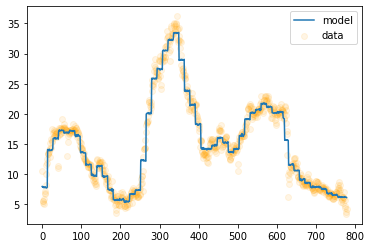

In [352]:
# plot model predictions to check it can reproduce the data
rng_key = random.PRNGKey(0)
predictive = Predictive(rw_model2, samples)
predictions = predictive(rng_key, X=X_,)["obs"]

plt.plot(jnp.median(predictions,axis=0), label='model')
plt.scatter(X_, df[['32 GiB']],alpha=0.1,c='orange', label='data')
plt.legend()
plt.show()

In [338]:
# model fits data ok

In [343]:
# now check the effect size and std dev for having a breakpoint at idx = 620,
# which is on the 28th of June
# Note, upgrade was July 6th at 1400 UTC
samples = mcmc.get_samples()
samples['covariate_effect_size'].mean(), samples['covariate_effect_size'].std()

(DeviceArray(0.81480265, dtype=float32),
 DeviceArray(0.03459448, dtype=float32))

In [ ]:
mcmc_from_numpyro = az.from_numpyro(mcmc)
az.plot_forest(mcmc_from_numpyro,var_names=['covariate_effect_size']);

In [339]:
# this seems sensible. A breakpoint close to the upgrade is associated with
# a significant decrease in onboarding

In [ ]:
# make a model to iterate over a range of breakpoints

In [333]:
def rw_model2(y=None, X=None, breakpoint=599, periodicity=14):
    y_sigma = numpyro.sample('y_sigma', dist.HalfNormal(scale=1))
    covariate_effect_size = numpyro.sample('covariate_effect_size', dist.Normal(loc=1,scale=1))
    nsteps = X.shape[0] // periodicity
    mu = numpyro.sample('rw', dist.GaussianRandomWalk(scale=1, num_steps=nsteps))
    mu = jnp.repeat(mu, periodicity)
    mu = jnp.append(mu, jnp.repeat(mu[-1], X.shape[0] % periodicity))
    covariate = jnp.concatenate([jnp.repeat(1,breakpoint), 
                                 covariate_effect_size * jnp.repeat(1.,len(y_)-breakpoint)])
    mu *= covariate
    numpyro.sample('obs', dist.Normal(loc=mu, scale=y_sigma), obs=y)

idx_first_date = df[df['stateTime'] == '2022-05-01'].index[0]
idx_last_date = df[df['stateTime'] == '2022-09-01'].index[0]
effect_size_arr = []
for breakpoint_i in np.arange(idx_first_date, idx_last_date,3):
    mcmc = MCMC(
                NUTS(rw_model2), 
                num_warmup=500, num_samples=500)
    mcmc.run(random.PRNGKey(0), y=y_, X=X_,breakpoint=breakpoint_i,)
    samples = mcmc.get_samples()
    samps = list(np.array(samples['covariate_effect_size']))
    print(type(samps), type(effect_size_arr))
    effect_size_arr.append(samps)

sample: 100%|█████████████| 1000/1000 [00:03<00:00, 323.71it/s, 31 steps of size 1.77e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 332.90it/s, 15 steps of size 2.06e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 332.27it/s, 15 steps of size 2.27e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 326.23it/s, 31 steps of size 1.87e-01. acc. prob=0.93]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 326.91it/s, 31 steps of size 1.59e-01. acc. prob=0.93]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:04<00:00, 210.98it/s, 15 steps of size 2.17e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 298.78it/s, 15 steps of size 2.58e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 315.63it/s, 15 steps of size 2.65e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 306.89it/s, 15 steps of size 2.33e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 316.26it/s, 31 steps of size 1.70e-01. acc. prob=0.93]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 328.26it/s, 15 steps of size 2.43e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 316.56it/s, 15 steps of size 2.53e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 319.20it/s, 15 steps of size 2.56e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 320.33it/s, 31 steps of size 1.98e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 319.87it/s, 15 steps of size 2.28e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 321.83it/s, 15 steps of size 2.62e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 306.39it/s, 15 steps of size 2.60e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 300.81it/s, 15 steps of size 2.46e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 323.15it/s, 15 steps of size 1.91e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 321.90it/s, 15 steps of size 2.48e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 317.96it/s, 15 steps of size 2.78e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 318.92it/s, 15 steps of size 2.76e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 318.08it/s, 15 steps of size 2.49e-01. acc. prob=0.90]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 314.64it/s, 15 steps of size 2.12e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 311.77it/s, 15 steps of size 1.97e-01. acc. prob=0.93]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 319.01it/s, 15 steps of size 2.00e-01. acc. prob=0.93]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 330.49it/s, 15 steps of size 2.24e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 328.75it/s, 31 steps of size 1.70e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 313.42it/s, 15 steps of size 2.26e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 319.89it/s, 15 steps of size 2.10e-01. acc. prob=0.93]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 324.90it/s, 15 steps of size 2.47e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 304.26it/s, 15 steps of size 2.15e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 311.22it/s, 31 steps of size 1.66e-01. acc. prob=0.94]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 313.26it/s, 31 steps of size 1.90e-01. acc. prob=0.93]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 325.41it/s, 15 steps of size 2.25e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 310.92it/s, 15 steps of size 2.22e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 317.62it/s, 15 steps of size 2.25e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 327.49it/s, 31 steps of size 2.01e-01. acc. prob=0.91]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 328.59it/s, 15 steps of size 2.29e-01. acc. prob=0.90]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:03<00:00, 319.69it/s, 15 steps of size 2.58e-01. acc. prob=0.90]


<class 'list'> <class 'list'>


sample: 100%|█████████████| 1000/1000 [00:05<00:00, 178.86it/s, 31 steps of size 1.94e-01. acc. prob=0.92]


<class 'list'> <class 'list'>


In [356]:
# plot onboarding breakpoint effect size vs date

In [354]:
effect_size = {df['stateTime'].iloc[idx_first_date+2*i]: effect_size_arr[i] 
               for i in range(0,len(effect_size_arr))}

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

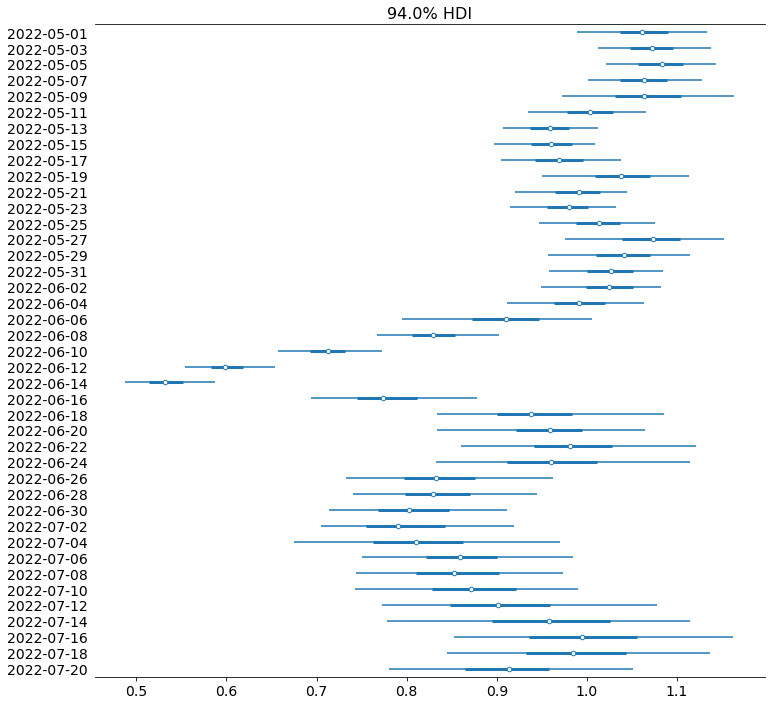

In [355]:
az.plot_forest(az.from_dict(effect_size), figsize=(12, 12))

**Interpretation**
* Skyr upgrade happened on 6th of July.
* The model detects a maximum effect size for a breakpoint in onboarding a week later on 14th of July.
* The breakpoint effect size in onboarding is a substantial permanent decrease:
    * Substantial meaing a ~40%+ decrease in  onboarding happened.
    * Permanent meaning from the date of upgrade until today. Things may change tomorrow.
    * Thie decrease is statistically significant in the sense the effect size estimated has narrow credible intervals. Note the model takes a strong prior of no effect of multiplicative N(1,0.1), or no change is the default.
* A plausible causal mechanism is that the the 2x change in gas price with Skyr decreased SP ROI estimates.